## 1. Import necessary libraries

In [97]:
import pandas as pd
import os 
from functools import reduce
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [61]:
folder_path = '/Users/AnhHuynh/Documents/CS504-006-Team2/data/monthly_data'  # Replace with your path
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

csv_dfs = []

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    # Convert to datetime
    df['observation_date'] = pd.to_datetime(df['observation_date'])

    csv_dfs.append(df)

In [62]:
# Read in quarterly GDP data
gdp = pd.read_csv("data/GDPC1-quarterly.csv")

## 2. Transform quarterly data to monthly data

In [63]:
def expand_quarterly_to_monthly(df, value_col):
    """
    Expand a quarterly dataset to monthly frequency by evenly distributing the value
    over the 3 months in each quarter.

    Parameters:
        df (pd.DataFrame): Input DataFrame with 'observation_date' and value column.
        value_col (str): Name of the column containing quarterly values.

    Returns:
        pd.DataFrame: Expanded monthly DataFrame.
    """
    df['observation_date'] = pd.to_datetime(df['observation_date'])

    def expand_row(row):
        base_date = row['observation_date']
        monthly_value = row[value_col] / 3
        return pd.DataFrame({
            'observation_date': [base_date, base_date + pd.DateOffset(months=1), base_date + pd.DateOffset(months=2)],
            value_col: [monthly_value] * 3
        })

    monthly_df = pd.concat([expand_row(row) for _, row in df.iterrows()], ignore_index=True)
    monthly_df.sort_values('observation_date', inplace=True)
    monthly_df.reset_index(drop=True, inplace=True)
    return monthly_df

## 3. Apply transformation function to quarterly datasets

In [64]:
gpd_monthly = expand_quarterly_to_monthly(gdp, "GDPC1")

In [65]:
T10Y3M = pd.read_csv("data/T10Y3M-dailycsv.csv")

T10Y3M['observation_date'] = pd.to_datetime(T10Y3M['observation_date'])

# Resample to monthly (you can also use 'sum', 'max', etc.)
T10Y3M_monthly = T10Y3M.resample('MS', on='observation_date').mean().reset_index()

## 4. Combine all dataframes

In [66]:
all_dfs = csv_dfs + [gpd_monthly, T10Y3M_monthly]

In [67]:
merged_df = reduce(lambda left, right: pd.merge(left, right, on='observation_date', how='outer'), all_dfs)

# --- Step 4: Sort and export ---
merged_df.sort_values('observation_date', inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# Output preview
print(merged_df.head(50))


   observation_date  CSUSHPINSA  HOUST  MSACSRNSA  USREC  FEDFUNDS        RPI  \
0        2006-01-01     180.828   2273        5.9      0      4.29  13214.527   
1        2006-02-01     181.500   2119        6.1      0      4.49  13283.182   
2        2006-03-01     182.749   1969        5.1      0      4.59  13340.072   
3        2006-04-01     183.648   1821        5.6      0      4.79  13347.045   
4        2006-05-01     184.380   1942        5.5      0      4.94  13336.874   
5        2006-06-01     184.547   1802        5.8      0      4.99  13353.303   
6        2006-07-01     184.607   1737        6.9      0      5.24  13342.387   
7        2006-08-01     184.404   1650        6.5      0      5.25  13329.621   
8        2006-09-01     184.198   1720        7.0      0      5.25  13408.301   
9        2006-10-01     184.053   1491        7.5      0      5.25  13479.950   
10       2006-11-01     183.630   1570        7.8      0      5.25  13547.935   
11       2006-12-01     183.

## 5. Save as a csv file

In [68]:
merged_df.to_csv("combined_dataset.csv", index=False)

## 6. Exploratory Cleansing

In [69]:
# Read data
data = pd.read_csv("combined_dataset.csv")

data.head()

,observation_date,CSUSHPINSA,HOUST,MSACSRNSA,USREC,FEDFUNDS,RPI,PCEPI,GDPC1,T10Y3M
0,2006-01-01,180.828,2273,5.9,0,4.29,13214.527,83.534,5451.278333,0.080000
1,2006-02-01,181.500,2119,6.1,0,4.49,13283.182,83.584,5451.278333,0.029474
2,2006-03-01,182.749,1969,5.1,0,4.59,13340.072,83.746,5451.278333,0.096087
3,2006-04-01,183.648,1821,5.6,0,4.79,13347.045,84.135,5465.383667,0.268947
4,2006-05-01,184.380,1942,5.5,0,4.94,13336.874,84.361,5465.383667,0.273636


In [70]:
# Rename columns for readability
rename_dict = {
    'observation_date': 'Date',
    'CSUSHPINSA': 'house_price_index',
    'HOUST': 'new_private_house_owned',
    'MSACSRNSA': 'home_supply',
    'FEDFUNDS': 'federal_rate',
    'RPI': 'real_income',
    'PCEPI': 'consumption_price_index',
    'USREC': 'recession_indicator',
    'GDPC1': 'gdp',
    'T10Y3M': 'treasury_maturity'
}

data = data.rename(columns=rename_dict)

In [71]:
# Display sample dataset
data.head()

,Date,house_price_index,new_private_house_owned,home_supply,recession_indicator,federal_rate,real_income,consumption_price_index,gdp,treasury_maturity
0,2006-01-01,180.828,2273,5.9,0,4.29,13214.527,83.534,5451.278333,0.080000
1,2006-02-01,181.500,2119,6.1,0,4.49,13283.182,83.584,5451.278333,0.029474
2,2006-03-01,182.749,1969,5.1,0,4.59,13340.072,83.746,5451.278333,0.096087
3,2006-04-01,183.648,1821,5.6,0,4.79,13347.045,84.135,5465.383667,0.268947
4,2006-05-01,184.380,1942,5.5,0,4.94,13336.874,84.361,5465.383667,0.273636


In [72]:
data['recession_indicator'].unique()

array([0, 1])

In [73]:
# Descriptive statistics
data.describe()

,house_price_index,new_private_house_owned,home_supply,recession_indicator,federal_rate,real_income,consumption_price_index,gdp,treasury_maturity
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,157.274500,941.273810,7.785714,0.214286,1.783929,13943.014560,89.569774,5600.528976,1.857878
std,17.585056,456.058608,2.263548,0.412790,2.171063,446.601342,3.278411,120.812424,1.315366
min,133.991000,478.000000,4.200000,0.000000,0.070000,13214.527000,83.534000,5423.048333,-0.515455
25%,143.156500,587.500000,6.100000,0.000000,0.147500,13608.611500,87.252000,5499.467667,0.526776
50%,148.377000,731.500000,7.550000,0.000000,0.190000,13850.489500,89.745000,5608.765000,2.124286
75%,177.927250,1213.750000,9.300000,0.000000,4.490000,14304.834250,92.263750,5659.492083,3.089341
max,184.607000,2273.000000,14.300000,1.000000,5.260000,15333.647000,95.174000,5829.950667,3.684545


In [74]:
# Checking for null values
data.isnull().sum()

Date                       0
house_price_index          0
new_private_house_owned    0
home_supply                0
recession_indicator        0
federal_rate               0
real_income                0
consumption_price_index    0
gdp                        0
treasury_maturity          0
dtype: int64

In [75]:
# Checking for data types
data.dtypes

Date                        object
house_price_index          float64
new_private_house_owned      int64
home_supply                float64
recession_indicator          int64
federal_rate               float64
real_income                float64
consumption_price_index    float64
gdp                        float64
treasury_maturity          float64
dtype: object

In [84]:
# Transform Date value to correct datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [85]:
data.dtypes

Date                       datetime64[ns]
house_price_index                 float64
new_private_house_owned             int64
home_supply                       float64
recession_indicator                 int64
federal_rate                      float64
real_income                       float64
consumption_price_index           float64
gdp                               float64
treasury_maturity                 float64
dtype: object

## 7. Data Visualization

## 8. Exploratory Data Analysis

/var/folders/4p/strpkrbd1y782g01xksphyv40000gn/T/ipykernel_17294/2738912161.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm')


<Axes: >

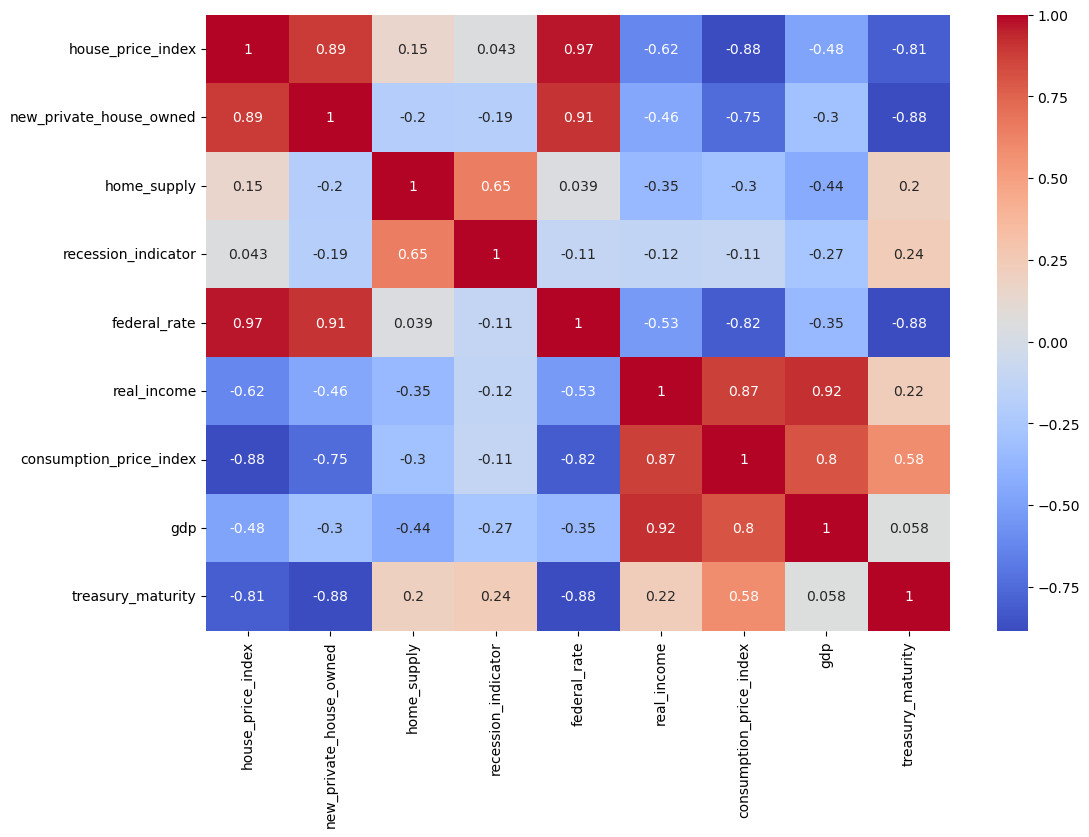

In [102]:
# Correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

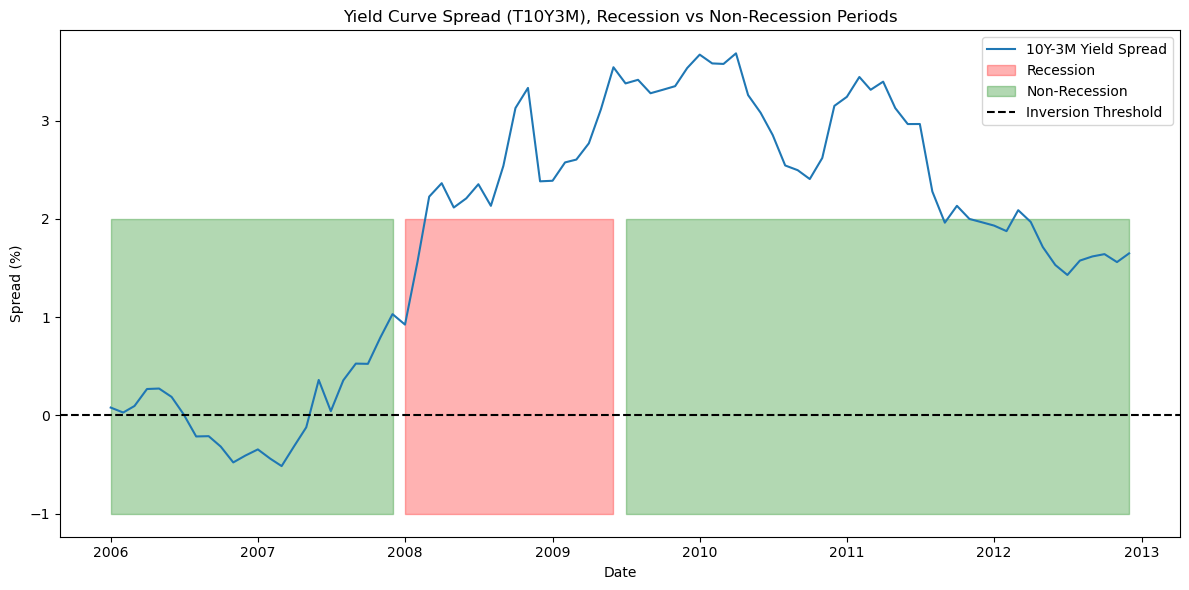

In [103]:
plt.figure(figsize=(12, 6))

# Plot the treasury maturity (yield curve)
sns.lineplot(data=data, x='Date', y='treasury_maturity', label='10Y-3M Yield Spread')

# Highlight recession periods
plt.fill_between(
    data['Date'],
    -1, 2,
    where=data['recession_indicator'] == 1,
    color='red',
    alpha=0.3,
    label='Recession'
)

# Highlight non-recession periods (optional: choose a different color or transparency)
plt.fill_between(
    data['Date'],
    -1, 2,
    where=data['recession_indicator'] == 0,
    color='green',
    alpha=0.3,
    label='Non-Recession'
)

# Horizontal line at 0 to indicate yield curve inversion
plt.axhline(0, linestyle='--', color='black', label='Inversion Threshold')

# Title and labels
plt.title('Yield Curve Spread (T10Y3M), Recession vs Non-Recession Periods')
plt.ylabel('Spread (%)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()


In [104]:
# Compare mean of economic indicators of pre and post 2008 recession
data['period'] = data['Date'].apply(lambda x: 'Pre-2008' if x < pd.to_datetime('2008-01-01') else 'Post-2008')

data.groupby('period')[[
    'house_price_index', 'new_private_house_owned', 'home_supply',
    'federal_rate', 'real_income', 'consumption_price_index', 'gdp'
]].mean()

,house_price_index,new_private_house_owned,home_supply,federal_rate,real_income,consumption_price_index,gdp
period,,,,,,,
Post-2008,147.499517,687.033333,7.906667,0.500833,14087.976550,91.188367,5627.701033
Pre-2008,181.711958,1576.875000,7.483333,4.991667,13580.609583,85.523292,5532.598833


### Explanation

In [105]:
# Hypothesis testing
import statsmodels.api as sm

X = sm.add_constant(data['treasury_maturity'])
y = data['recession_indicator']
model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.488174
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     recession_indicator   No. Observations:                   84
Model:                           Logit   Df Residuals:                       82
Method:                            MLE   Df Model:                            1
Date:                 Thu, 17 Apr 2025   Pseudo R-squ.:                 0.06044
Time:                         16:59:28   Log-Likelihood:                -41.007
converged:                        True   LL-Null:                       -43.645
Covariance Type:             nonrobust   LLR p-value:                   0.02162
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.3940      0.636     -3.763      0.000      -3.641      -1.147


### Hypothesis testing

**Hypothesis**:

* H0: There is no relationship between yield curve and probability of recession.
* H1: There is statistically significant relationship between yield curve and probability of recession.

**Testing metric**

* p-value < 0.05: There is a statistically significant relationship between yield curve and probability of recesssion.
* p-value >= 0.05: There is no relationship between yield curve and probability of recession

**Result**

* In our logistic regression result, the p-value is 0.02162, which is less than 0.05, meaning that there is a statistically significant relationship between yield curve and probability of recession